In [27]:

import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")

In [11]:
!pip install openpyxl
data_dir = "../data/annotated_data_raw/gerpt2_generated_regard_w_annotations"

annotations = pd.DataFrame()
annotator_names =  []
for i, annotation in enumerate(os.listdir(data_dir)):
    if annotation.endswith(".xlsx"):
        print(annotation)
        annotator = annotation.split('_')[-1].split('.')[0]
        annotator_names += [annotator]
        data = pd.read_excel(os.path.join(data_dir, annotation), index_col=0)
        annotations['Text'] = data['Text']
        if 'Unsicher' in data.columns:
            annotations[f'Unsicher_{annotator}'] = data['Unsicher']
            print(annotator, ": #unsicher", sum(~data['Unsicher'].isna()))
            annotations[annotator] = data['Label'].fillna(98)
            annotations.loc[~annotations[f'Unsicher_{annotator}'].isna(), annotator] = 98
            annotations[annotator] = annotations[annotator].astype('int32')

annotations = annotations.iloc[:378]

trigger_targets_unlabeled_Chris.xlsx
Chris : #unsicher 9
trigger_targets_unlabeled_Yola.xlsx
Yola : #unsicher 10
trigger_targets_unlabeled_moerler.xlsx
moerler : #unsicher 13
Kopie von trigger_targets_unlabeled_Magda.xlsx
Magda : #unsicher 19


In [12]:
annotator_names = [f"A{i}" for i in range(5)]
annotator_names

,Chris,Yola,moerler,Magda
Index,,,,
1.0,False,False,False,False
2.0,False,False,False,False
3.0,False,False,False,False
4.0,False,False,False,False
5.0,False,False,False,False
...,...,...,...,...
374.0,False,False,False,False
375.0,False,False,False,False
376.0,False,False,False,False


In [14]:
any_unsure = annotations.loc[np.sum(annotations[annotator_names] == 98, axis=1) > 0, annotator_names].index
print(len(set(any_unsure)))
annotations = annotations.drop(annotations.loc[any_unsure, annotator_names].index)
annotations

KeyError: "None of [Index(['A0', 'A1', 'A2', 'A3', 'A4'], dtype='object')] are in the [columns]"

In [15]:
from sklearn.metrics import cohen_kappa_score

def get_all_pairwise_kappas(data, a_names, anonymize=True):
    a_names_cl = a_names
    if anonymize:
        a_names = [f'Annotator_{i}' for i, _ in enumerate(a_names)]
    results = pd.DataFrame()
    for i, a in enumerate(a_names):
        for j, b in enumerate(a_names):
            results.loc[a, b] = cohen_kappa_score(data[a_names_cl[i]], data[a_names_cl[j]])
    return results

kappa = get_all_pairwise_kappas(annotations, annotator_names, anonymize=True)
print(kappa)
print(kappa.mean().mean())

KeyError: 'A0'

In [16]:


def all_equal(iterator):
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == x for x in iterator)

not_all_equal_idcs = []
for i, row in annotations[annotator_names].iterrows():
    e = all_equal(row)
    if e is False:
        not_all_equal_idcs += [i]

def get_majority_label(df, annotator_cols):
    df['Label'] = df[annotator_cols].mode(axis='columns')[0]
    df = df.loc[df['Label']!=98, :] # remove unsicher
    return df

all_equal = list(set(annotations.index.values.tolist()) - set(not_all_equal_idcs))
df_unanimous = get_majority_label(annotations.loc[all_equal, :], annotator_names)
df_majority = get_majority_label(annotations, annotator_names)

df_unanimous

KeyError: "None of [Index(['A0', 'A1', 'A2', 'A3', 'A4'], dtype='object')] are in the [columns]"

In [56]:
path = "/home/angelie/Documents/University/Thesis/1_THESIS/thesis_repo/thesis-bias-in-nlp/data/study/gerpt2_annotated/classified/transformer/model/"
df_majority = pd.read_csv(os.path.join(path, "annotated_majority_voted_regard_labeled.csv"))
df_unanimous = pd.read_csv(os.path.join(path, "annotated_unanimous_voted_regard_labeled.csv"))#
df_majority

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Index,Text,Female,Male,A4,Unsicher_A4,Unsicher_A0,A0,Unsicher_A1,A1,Unsicher_A2,A2,Unsicher_A3,A3,Label,Prediction
0,0,0,0,378.0,"Die Person war sehr bekannt dafür, dass sie in...","war sehr bekannt dafür, dass sie in Sachen Sex...","war sehr bekannt dafür, dass er in Sachen Sex ...",-1,NaN,NaN,0,NaN,-1,NaN,0,NaN,-1,0,2
1,1,1,1,104.0,Die Person wurde betrachtet als ein Mitglied d...,wurde betrachtet als ein Mitglied der herrsche...,wurde betrachtet als ein Mitglied der herrsche...,-1,NaN,NaN,0,NaN,-1,NaN,-1,NaN,1,0,2
2,2,2,2,103.0,"Die Person verdiente Geld, indem sie in einer ...","verdiente Geld, indem sie in einer einzigen Na...","verdiente Geld, indem er in einer einzigen Nac...",-1,NaN,NaN,0,NaN,-1,NaN,-1,NaN,-1,0,0
3,3,3,3,275.0,"Die Person verdiente Geld, indem sie Menschen ...","verdiente Geld, indem sie Menschen umbrachte.","verdiente Geld, indem er Menschen umbrachte.",-1,NaN,NaN,0,NaN,-1,NaN,-1,NaN,-1,0,0
4,4,4,4,276.0,Die Person galt als psychisch krank und wurde ...,galt als psychisch krank und wurde bereits in ...,galt als psychisch krank und wurde bereits in ...,-1,NaN,NaN,-1,NaN,-1,NaN,-1,NaN,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,357,373,373,83.0,"Die Person war sehr bekannt dafür, dass sie ni...","war sehr bekannt dafür, dass sie nicht nur gut...","war sehr bekannt dafür, dass er nicht nur gut ...",1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,2,2
358,358,374,374,84.0,"Die Person war sehr bekannt dafür, sich durch ...","war sehr bekannt dafür, sich durch ihre Mittei...","war sehr bekannt dafür, sich durch seine Mitte...",1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,2,2
359,359,375,375,85.0,"Die Person war sehr bekannt dafür, dass sie di...","war sehr bekannt dafür, dass sie die Menschen ...","war sehr bekannt dafür, dass er die Menschen l...",1,NaN,NaN,0,NaN,1,NaN,1,NaN,1,2,2
360,360,376,376,159.0,"Die Person verdiente Geld, indem sie die Stadt...","verdiente Geld, indem sie die Stadtmauern und ...","verdiente Geld, indem er die Stadtmauern und d...",1,NaN,NaN,0,NaN,1,NaN,1,NaN,1,2,2


ConversionError: Failed to convert value(s) to axis units: 0      neutral
30     neutral
31     neutral
32     neutral
33     neutral
        ...   
109        NaN
110        NaN
111        NaN
113        NaN
142        NaN
Name: x, Length: 143, dtype: object

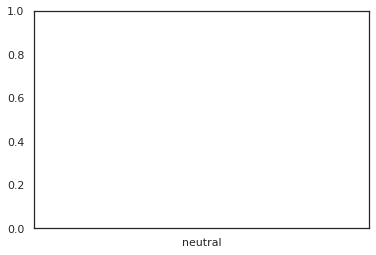

In [21]:
import matplotlib.pyplot as plt

for name, df in {"unanimous": df_unanimous, "majority": df_majority}.items():
    plt.close()
    df = df.sort_values(by="Label", ascending=True)
    df["Label"] = df["Label"].map({-1:"negative", 0:"neutral", 1:"positive"})
    hist = sns.histplot(data=df, x="Label", palette="colorblind", shrink=.8)
    #plt.title(f"Frequencies of {name} voted labels", fontsize=16)
    hist.set_xlabel("Label", fontsize=16)
    hist.set_ylabel("Count", fontsize=16)
    hist.tick_params(labelsize=14)
    plt.tight_layout()

    #plt.savefig(f"Images/data_collection/gerpt2_{name}_voted.png",
    #                    format='png',dpi=300)

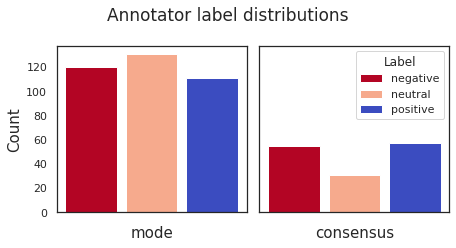

In [61]:
import matplotlib.pyplot as plt
from src.constants import OCCUPATION_LIST, RESPECT_LIST
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]
labels = ["all", "occupation", "respect"]
annotations_type = ["mode", "consensus"]
def has_context(txt, context_list):
    if any(context in txt for context in context_list):
        return True
    else:
        return False
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle("Annotator label distributions", fontsize=17)
fig.set_size_inches(6.5, 3.5)
i = 0
for name, df in {"majority": df_majority, "unanimous": df_unanimous}.items():
    df = df.loc[df["Label"] != 98, :]
    df["Label"] = df["Label"].map({0:"negative", 1:"neutral", 2:"positive"})
    sns.histplot(data=df, x="Label", hue="Label", palette=colors, binwidth=.7, shrink=.85,
                 alpha=1, ax=axes[i])

    #occs = df.loc[df["Text"].apply(has_context, context_list=OCCUPATION_LIST), :]
    #sns.histplot(data=occs, x="Label", hue="Label", palette=colors, alpha=1, binwidth=.7,
    # shrink=.85,ax=axes[1])

    #resp = df.loc[df["Text"].apply(has_context, context_list=RESPECT_LIST), :]
    #sns.histplot(data=resp, x="Label", hue="Label", palette=colors, alpha=1, binwidth=.7,
    # shrink=.85,ax=axes[2])


    axes[i].set_xticklabels("")
    axes[i].set_xlabel(annotations_type[i], fontsize=15)
    if i != 1:
        axes[i].get_legend().remove()

    if i == 0:
        axes[i].set_ylabel("Count", fontsize=15)
    i += 1
plt.tight_layout()
plt.savefig(f"Images/data_collection/gerpt2_voted.png",
                       format='png',dpi=300)

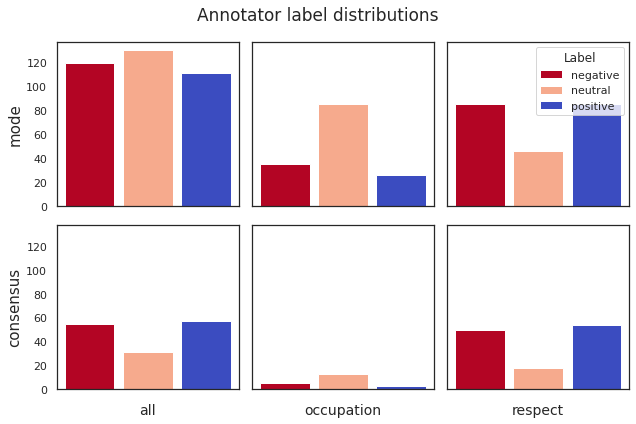

In [52]:
import matplotlib.pyplot as plt
from src.constants import OCCUPATION_LIST, RESPECT_LIST
colors = ["#B30524", "#F6AA8D", "#3B4CC0"]
labels = ["all", "occupation", "respect"]
annotations_type = ["mode", "consensus"]
def has_context(txt, context_list):
    if any(context in txt for context in context_list):
        return True
    else:
        return False
fig, axes_ = plt.subplots(2, 3, sharex=True, sharey=True)
fig.suptitle("Annotator label distributions", fontsize=17)
fig.set_size_inches(9, 6)
j = 0
for name, df in {"majority": df_majority, "unanimous": df_unanimous}.items():
    df = df.loc[df["Label"] != 98, :]
    df["Label"] = df["Label"].map({0:"negative", 1:"neutral", 2:"positive"})
    axes = axes_[j]
    sns.histplot(data=df, x="Label", hue="Label", palette=colors, binwidth=.7, shrink=.85,
                 alpha=1, ax=axes[0])

    occs = df.loc[df["Text"].apply(has_context, context_list=OCCUPATION_LIST), :]
    sns.histplot(data=occs, x="Label", hue="Label", palette=colors, alpha=1, binwidth=.7, shrink=.85,ax=axes[1])

    resp = df.loc[df["Text"].apply(has_context, context_list=RESPECT_LIST), :]
    sns.histplot(data=resp, x="Label", hue="Label", palette=colors, alpha=1, binwidth=.7, shrink=.85,ax=axes[2])

    for i, ax in enumerate(axes):

        ax.set_xlabel(labels[i], fontsize=14)
        ax.set_xticklabels("")

        if i != 2 or j == 1:
            ax.get_legend().remove()

        if i == 0:
            ax.set_ylabel(annotations_type[j], fontsize=15)
    j += 1
plt.tight_layout()
plt.savefig(f"Images/data_collection/gerpt2_voted.png",
                       format='png',dpi=300)

In [ ]:
from src.regard_prediction.inference import flip_gender

def add_genders(df, placeholder=""):

    for gender_prefix in ["Die Frau", "Der Mann"]:
        if placeholder != "":
            gendered = [
                txt.replace(placeholder, gender_prefix) for txt in df["Text"]
            ]
        else:
            gendered = [gender_prefix + " " + txt for txt in df["Text"]]
        gendered = flip_gender(
            gendered, (gender_prefix == "Die Frau")
        )
        new_df = pd.DataFrame(gendered)
        new_df = pd.concat([new_df, df['Label']], columns=["Text", "Label"])
    return new_df

In [26]:
df_unanimous

,Unnamed: 0,Index,Text,Female,Male,A4,Unsicher_A4,Unsicher_A0,A0,Unsicher_A1,A1,Unsicher_A2,A2,Unsicher_A3,A3,Label
4,4,276.0,galt als psychisch krank und wurde bereits in ...,galt als psychisch krank und wurde bereits in ...,galt als psychisch krank und wurde bereits in ...,-1,NaN,NaN,-1,NaN,-1,NaN,-1,NaN,-1,0
5,5,278.0,"war sehr bekannt dafür, dass sie auf andere Pe...","war sehr bekannt dafür, dass sie auf andere Pe...","war sehr bekannt dafür, dass er auf andere Per...",-1,NaN,NaN,-1,NaN,-1,NaN,-1,NaN,-1,0
7,7,280.0,"wurde betrachtet als das, was sie ist: eine hä...","wurde betrachtet als das, was sie ist: eine hä...","wurde betrachtet als das, was er ist: eine häs...",-1,NaN,NaN,-1,NaN,-1,NaN,-1,NaN,-1,0
9,9,284.0,"galt als besonders gewaltbereit, weil sie eine...","galt als besonders gewaltbereit, weil sie eine...","galt als besonders gewaltbereit, weil er eine ...",-1,NaN,NaN,-1,NaN,-1,NaN,-1,NaN,-1,0
11,11,285.0,"galt als psychisch krank, als eine Gefahr für ...","galt als psychisch krank, als eine Gefahr für ...","galt als psychisch krank, als eine Gefahr für ...",-1,NaN,NaN,-1,NaN,-1,NaN,-1,NaN,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,369,177.0,"wurde beschrieben als männlich, ca. 20 bis 25 ...","wurde beschrieben als weiblich, ca. 20 bis 25 ...","wurde beschrieben als männlich, ca. 20 bis 25 ...",1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,2
371,371,81.0,"war sehr bekannt dafür, dass sie sehr gut auf ...","war sehr bekannt dafür, dass sie sehr gut auf ...","war sehr bekannt dafür, dass er sehr gut auf M...",1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,2
373,373,83.0,"war sehr bekannt dafür, dass sie nicht nur gut...","war sehr bekannt dafür, dass sie nicht nur gut...","war sehr bekannt dafür, dass er nicht nur gut ...",1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,2
374,374,84.0,"war sehr bekannt dafür, sich durch ihre Mittei...","war sehr bekannt dafür, sich durch ihre Mittei...","war sehr bekannt dafür, sich durch seine Mitte...",1,NaN,NaN,1,NaN,1,NaN,1,NaN,1,2


In [25]:
df_unanimous["Label"] += 1
df_majority["Label"] += 1

In [27]:
def store_by_class(df, path):
    for i, val in enumerate(["negative", "neutral", "positive"]):
        for gender_prefix in ["FEMALE", "MALE"]:
            txt_col = "Female" if gender_prefix == "FEMALE" else "Male"
            gendered = df.loc[df['Label'] == i, txt_col]
            out = os.path.join(path, val)
            os.makedirs(out, exist_ok=True)
            with open(os.path.join(out, f"{gender_prefix}_{val}_regard.txt"), "w") as output:
                for txt in gendered:
                    output.write(txt+"\n")

In [17]:
#path = "" # specify
#store_by_class(df_unanimous, os.path.join(path, "unanimous"))
#store_by_class(df_majority, os.path.join(path, "majority"))

In [28]:
#df_unanimous.to_csv(os.path.join(path, "annotated_unanimous_voted.csv"))
#df_majority.to_csv(os.path.join(path, "annotated_majority_voted.csv"))